# Random Forest Guided Example
Raj Prasad
June 2019

This is an assignment for my thinkful data science course.  The goal is to improve on a random forest model. 

[html version of this notebook](https://daddyprasad5.github.io/random_forest_guided_example.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/random_forest_guided_example.ipynb) - with all the code exposed in an interactive notebook


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [2]:
# Replace the path with the correct path for your data.
raw_2015 = pd.read_csv('LoanStats3d.csv', skipinitialspace=True, header=1)

# Note the warning about dtypes.

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015 = raw_2015
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,24700.0,24700.0,24700.0,36 months,11.99%,820.28,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,35000.0,35000.0,35000.0,60 months,14.85%,829.90,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,3600.0,3600.0,3600.0,36 months,13.99%,123.03,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10400.0,10400.0,10400.0,60 months,22.45%,289.91,F,F1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,20000.0,20000.0,20000.0,60 months,10.78%,432.66,B,B4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#looking at unique values for each categorical column
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
2
term
2
int_rate
111
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
2
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
53
next_pymnt_d
5
last_credit_pull_d
54
application_type
2
verification_status_joint
1
hardship_flag
2
hardship_type
1
hardship_reason
9
hardship_status
3
hardship_start_date
28
hardship_end_date
29
payment_plan_start_date
29
hardship_loan_status
4
debt_settlement_flag
2
debt_settlement_flag_date
46
settlement_status
3
settlement_date
49


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [5]:
# Convert ID and Interest Rate to numeric.
y2015 = y2015[:-2]

y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  er

## Second Attempt

drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.


In [6]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

#cross_val_score(rfc, X, Y, cv=10)

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [7]:
cont_cols = list(X.columns.values)

Fully Paid            302420
Charged Off            76600
Current                40215
Late (31-120 days)      1144
In Grace Period          438
Late (16-30 days)        277
Default                    1
Name: loan_status, dtype: int64

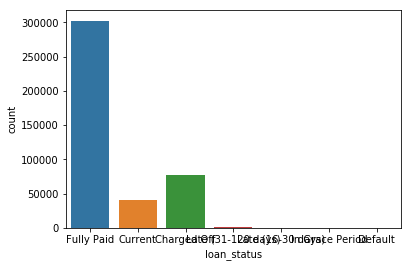

In [8]:
#let's peak at the distribution of our target variable
import seaborn as sns

sns.countplot(x="loan_status", data=y2015)
y2015.loan_status.value_counts()

In [9]:
display(y2015[y2015.loan_status == "Default"])

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
32903,NaN,NaN,24000.0,24000.0,24000.0,60 months,16.55,590.68,D,10+ years,...,NaN,NaN,NaN,Y,Apr-2019,ACTIVE,Apr-2019,5437.0,45.0,18.0


In [10]:
#find missing values and drop columns with a large number of them

def find_nulls(df): 
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

nulls_df = find_nulls(y2015).reset_index()
nulls_df.columns = ["column", "row_count", "percent_missing"]
y2015 = y2015.drop(nulls_df.loc[nulls_df.percent_missing > .60, "column"].values, axis=1)
nulls_df = find_nulls(y2015).reset_index()
nulls_df.columns = ["column", "row_count", "percent_missing"]

In [11]:
nulls_df

,column,row_count,percent_missing
0,mths_since_last_delinq,203962,0.484361
1,mths_since_recent_inq,44599,0.105912
2,emp_length,23817,0.056560
3,num_tl_120dpd_2m,19230,0.045667
4,mo_sin_old_il_acct,12254,0.029100
5,percent_bc_gt_75,4239,0.010067
6,bc_util,4227,0.010038
7,bc_open_to_buy,3963,0.009411
8,mths_since_recent_bc,3798,0.009019
9,last_pymnt_d,294,0.000698


In [12]:
#with just 81 columns, we are still over our 90% bar and the variability in quality in the cross-validations is improved. 
rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)


In [13]:
cross_val_score(rfc, X, Y, cv=10)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklea

array([0.99123765, 0.99213982, 0.99142742, 0.992686  , 0.993327  ,
       0.99278064, 0.99356432, 0.99299421, 0.99304154, 0.99256656])

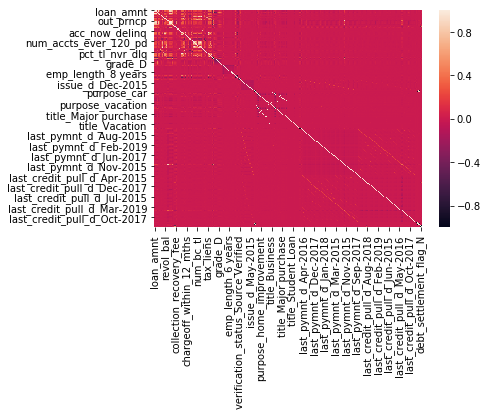

In [14]:
#there are definitely some pockets of high correlation in the predictors, so we should try PCA
corrs = X.corr()
sns.heatmap(corrs)
plt.show()

In [ ]:
#PCA compenents still meet our 90% bar - even with just 30 components
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X_standard = StandardScaler().fit_transform(X)



In [17]:
sklearn_pca = PCA(n_components=30)
X_sklearn = sklearn_pca.fit_transform(X_standard)

cross_val_score(rfc, X_sklearn, Y, cv=10)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklea

array([0.93270327, 0.93201301, 0.9343402 , 0.93804469, 0.93469485,
       0.93797051, 0.93604693, 0.93200817, 0.9358064 , 0.93162657])

In [21]:
#find the 10 most correlated with each one-hot of the target variable, and use that superset to predict
from scipy.stats import pearsonr

y_dummies = pd.get_dummies(Y)

y_col = []
best_cols = pd.DataFrame({"x_col":[], "corr":[], "y_col":[]})
for coly in y_dummies: 
    x_col = []
    corr = []
    y_col.append(coly)
    for colx in X:
        x_col.append(colx)
        corr.append(abs(pearsonr(X[colx], y_dummies[coly])[0]))
    best_corrs = pd.DataFrame({"x_col": x_col, "corr": corr}).sort_values(by="corr", ascending=False).head(1)
    best_corrs["y_col"] = coly
    best_cols = pd.concat([best_cols, best_corrs], ignore_index=True)

best_cols_set = list(set(best_cols["x_col"].values))
print("the superset of highest correlated for each target variable one-hot is...")
print(best_cols_set)
print("there are {} predictors in this list".format(len(best_cols_set)))
    
X_best = X.loc[:, best_cols_set]

print

cross_val_score(rfc, X_best, Y, cv=10)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalar

the superset of highest correlated for each target variable one-hot is...
['last_pymnt_d_May-2019', 'last_pymnt_d_Apr-2019', 'debt_settlement_flag_Y', 'recoveries', 'last_pymnt_d_Mar-2019']
there are 5 predictors in this list


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklea

array([0.94293788, 0.94291278, 0.9441951 , 0.94343521, 0.94488245,
       0.94661474, 0.94792087, 0.94642348, 0.94637471, 0.94941459])

In [ ]:
#that does a hair better than the PCA with only 5 predictors. 